## 7. 파이토치 : 사람 얼굴 이미지 나이 예측 모델

### 데이터 세트 다운로드

In [10]:
%cd custom_korean_family_dataset_resolution_128

/home/jupyter_home/pingu/fc-data-signature/part1/chapter4/custom_korean_family_dataset_resolution_128


### 라이브러리 불러오기(Load Libraries)

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import pandas as pd
from PIL import Image
import os

### 데이터 세트 불러오기(Load Dataset)

In [14]:
def parsing(meta_data):
    image_age_list = []
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [15]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

    def __len__(self):
        return len(self.meta_data)
               
    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [16]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "train_images/"

val_meta_data_path = "custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "val_images/"

test_meta_data_path = "custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "test_images/"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = Dataset(val_meta_data, val_image_directory, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

### 데이터 시각화(Data Visualization)

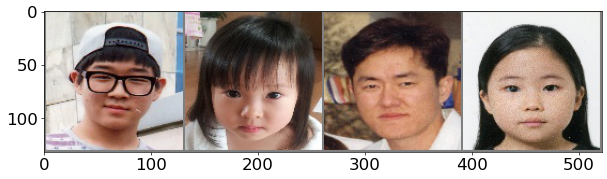

['13-19 years old', '0-6 years old', '31-45 years old', '7-12 years old']


In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.show()

iterator = iter(train_dataloader)

imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([label_to_age[labels[i].item()] for i in range(4)])

### 딥러닝 모델 학습(Training)

In [18]:
learning_rate = 0.01
log_step = 20

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [19]:
import time

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [20]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.06035735961049795, running train accuracy: 0.2640624940395355
[Batch: 40] running train loss: 0.05553819015622139, running train accuracy: 0.32421875
[Batch: 60] running train loss: 0.05196211164196332, running train accuracy: 0.36250001192092896
[Batch: 80] running train loss: 0.049230736983008686, running train accuracy: 0.3949218690395355
[Batch: 100] running train loss: 0.04729113258421421, running train accuracy: 0.414374977350235
[Batch: 120] running train loss: 0.04545036982744932, running train accuracy: 0.4364583492279053
[Batch: 140] running train loss: 0.04401486037032945, running train accuracy: 0.45446428656578064
[Batch: 160] running train loss: 0.042844483361113815, running train accuracy: 0.4677734375
[Batch: 180] running train loss: 0.041882124181009, running train accuracy: 0.4765625
[Batch: 200] running train loss: 0.04094861808232963, running train accuracy: 0.48499998450279236
[Batch: 220] running train loss: 

[Batch: 80] running train loss: 0.004855046272859908, running train accuracy: 0.952343761920929
[Batch: 100] running train loss: 0.004645547436084598, running train accuracy: 0.9556249976158142
[Batch: 120] running train loss: 0.004700590631303688, running train accuracy: 0.9541667103767395
[Batch: 140] running train loss: 0.00474434341802927, running train accuracy: 0.9526785612106323
[Batch: 160] running train loss: 0.004703941564366687, running train accuracy: 0.9525390863418579
[Batch: 180] running train loss: 0.0045811847389106534, running train accuracy: 0.9543402791023254
[Batch: 200] running train loss: 0.004576605496695265, running train accuracy: 0.9548436999320984
[Batch: 220] running train loss: 0.004562609532414089, running train accuracy: 0.9552556276321411
[Batch: 240] running train loss: 0.004491318679599014, running train accuracy: 0.9557292461395264
[Batch: 260] running train loss: 0.004423667040716212, running train accuracy: 0.9568509459495544
[Batch: 280] running t

[Batch: 160] running train loss: 0.0017971699140616692, running train accuracy: 0.9847656488418579
[Batch: 180] running train loss: 0.001782587528092942, running train accuracy: 0.9850694537162781
[Batch: 200] running train loss: 0.0017416263742779847, running train accuracy: 0.9856249690055847
[Batch: 220] running train loss: 0.0017572065808715044, running train accuracy: 0.9856534004211426
[Batch: 240] running train loss: 0.0017463142992104016, running train accuracy: 0.9858073592185974
[Batch: 260] running train loss: 0.0017733192789959364, running train accuracy: 0.9858173131942749
[Batch: 280] running train loss: 0.001775557324539737, running train accuracy: 0.985714316368103
[Batch: 300] running train loss: 0.0017860373518487904, running train accuracy: 0.9854167103767395
train loss: 0.0017567360260874554, accuracy: 0.9859351515769958
elapsed time: 35.71827435493469
[Epoch: 9 - Validation]
[Batch: 1] running val loss: 0.03019757568836212, running val accuracy: 0.71875
[Batch: 20]

### 학습 결과 확인하기

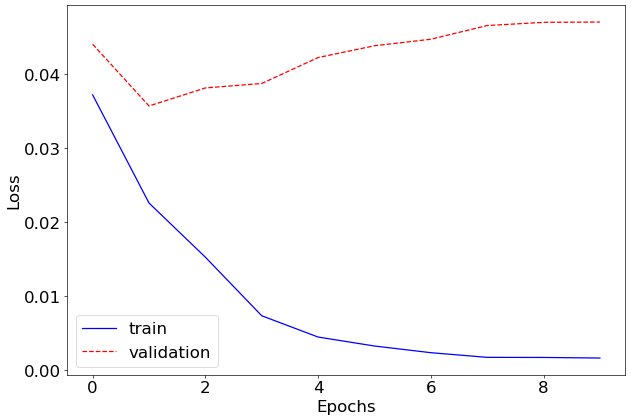

In [21]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

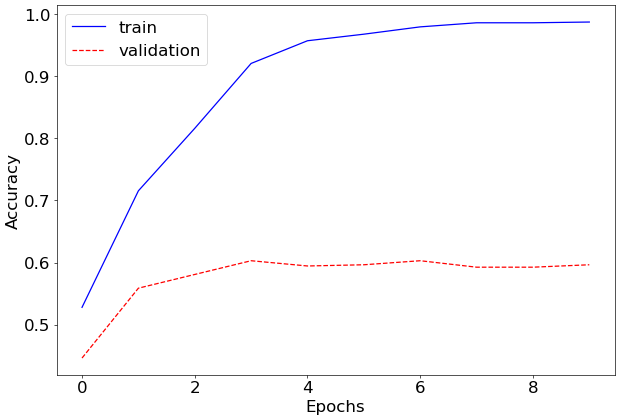

In [22]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [23]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)
model = model.cuda()
model_path = 'best_checkpoint_epoch_4.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.03605645149946213, running test accuracy: 0.6875
[Batch: 20] running test loss: 0.03526800721883774, running test accuracy: 0.635937511920929
[Batch: 40] running test loss: 0.031311033829115334, running test accuracy: 0.6507812738418579
test loss: 0.03146144345481979, accuracy: 0.6442819237709045
elapsed time: 2.023651361465454
Test loss: 0.03146144
Test accuracy: 64.43%
